In [ ]:
from datetime import datetime
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import dotenv_values
from sklearn.ensemble import ExtraTreesClassifier
from data.preprocessing import DataPreprocessor
from config import get_connection
from data.db import execute_sql, batched_read_notification_sql
from data.notifcation_preparation import *

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 10)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [119]:
conf = dotenv_values("../.env")

In [ ]:
conn = get_connection(conf)

In [121]:
notifications = batched_read_notification_sql(conn, subset=0)

Running batch id >= 0 and id < 1000
Running batch id >= 1000 and id < 2000
Running batch id >= 2000 and id < 3000
Running batch id >= 3000 and id < 4000
Running batch id >= 4000 and id < 5000
Running batch id >= 5000 and id < 6000
Running batch id >= 6000 and id < 7000
Running batch id >= 7000 and id < 8000
Running batch id >= 8000 and id < 9000
Running batch id >= 9000 and id < 10000
Running batch id >= 10000 and id < 11000
Running batch id >= 11000 and id < 12000
Running batch id >= 12000 and id < 13000
Running batch id >= 13000 and id < 14000
Running batch id >= 14000 and id < 15000
Running batch id >= 15000 and id < 16000
Running batch id >= 16000 and id < 17000
Running batch id >= 17000 and id < 18000
Running batch id >= 18000 and id < 19000
Running batch id >= 19000 and id < 20000
Running batch id >= 20000 and id < 21000
Running batch id >= 21000 and id < 22000
Running batch id >= 22000 and id < 23000
Running batch id >= 23000 and id < 24000
Running batch id >= 24000 and id < 250

In [361]:
len(notifications)

167139

In [362]:
notifications_list = flat_notifications_from_sql(notifications)

res = prepare_dataset(notifications_list)

In [363]:
res = DataPreprocessor.remove_partial_data(res)

In [364]:
raw = pd.DataFrame(data=res)
df = raw.reindex(sorted(raw.columns), axis=1)
df.shape

(165977, 736)

In [365]:
import os
LOCAL_DATA_PATH = os.path.join('..', 'data', 'DEV_20220901.parquet')
df.to_parquet(LOCAL_DATA_PATH)

In [229]:
raw.columns

Index(['id', 'ticker', 'price', 'notification_date', 'highest_since_notified',
       'lowest_since_notified', 'filter_name', 'same_signal_in_last_3_hour',
       'same_signal_in_last_24_hours', 'same_signal_profit_in_last_3_hours',
       ...
       'current_hour_bars_47_low', 'current_hour_bars_47_close',
       'current_hour_bars_47_volume', 'current_hour_bars_48_open',
       'current_hour_bars_48_high', 'current_hour_bars_48_low',
       'current_hour_bars_48_close', 'current_hour_bars_48_volume',
       'current_previouslyAccessed_24HoursBackMinute',
       'current_hourlyBarsTime'],
      dtype='object', length=736)

In [230]:
df = DataPreprocessor.remove_corrupt_data(df)
df.shape


(163054, 736)

In [231]:
# remove semi missing data 2022-05-11 to 2022-05-24
df = DataPreprocessor.remove_date_range(df,
                                        datetime.fromisoformat("2022-05-11"),
                                        datetime.fromisoformat("2022-05-24")
                                        )
df.shape

(162941, 736)

In [232]:
# remove semi missing data 2022-06-30 16:30 to 2022-07-02 11:17
df = DataPreprocessor.remove_date_range(df,
                                        datetime.fromisoformat("2022-06-30 16:30"),
                                        datetime.fromisoformat("2022-07-02 11:17")
                                        )
df.shape

(162758, 736)

In [233]:
df = DataPreprocessor.remove_most_recent_data(df)
df.shape

(161542, 736)

In [234]:
df = DataPreprocessor.add_regression_label_columns(df)
df.shape

(161542, 738)

In [235]:
df = DataPreprocessor.drop_categorical_features(df)
df.shape

(161542, 703)

In [236]:
#df.select_dtypes(include=['object'])

In [237]:
df = df.drop_duplicates(keep='first')
df.shape

(127556, 703)

In [238]:
# COMMENTED OUT
# drop columns with duplicated values, leave first one
#df = df.loc[:,~df.apply(lambda y: y.duplicated(),axis=1).all()].copy()
#df.shape
#df = DataPreprocessor.select_only_required_features(df)
#df.shape

In [239]:
from indicators.core import get_current_hourly_bars_cols

current_hourly_bars_closes = get_current_hourly_bars_cols(df, "close")

49

In [240]:
current_hourly_bars_highs = get_current_hourly_bars_cols(df, "high")

49

In [241]:
current_hourly_bars_lows = get_current_hourly_bars_cols(df, "low")

49

In [242]:
higher_high_cols_shift_1 = DataPreprocessor.add_higher_high_col(df)
df.loc[:, higher_high_cols_shift_1].tail()

Current hourly bars cols: 49


,HOUR_47_CLOSE_HIGHER_THAN_48,HOUR_46_CLOSE_HIGHER_THAN_47,HOUR_45_CLOSE_HIGHER_THAN_46,HOUR_44_CLOSE_HIGHER_THAN_45,HOUR_43_CLOSE_HIGHER_THAN_44,HOUR_42_CLOSE_HIGHER_THAN_43,HOUR_41_CLOSE_HIGHER_THAN_42,HOUR_40_CLOSE_HIGHER_THAN_41,HOUR_39_CLOSE_HIGHER_THAN_40,HOUR_38_CLOSE_HIGHER_THAN_39,HOUR_37_CLOSE_HIGHER_THAN_38,HOUR_36_CLOSE_HIGHER_THAN_37,HOUR_35_CLOSE_HIGHER_THAN_36,HOUR_34_CLOSE_HIGHER_THAN_35,HOUR_33_CLOSE_HIGHER_THAN_34,HOUR_32_CLOSE_HIGHER_THAN_33,HOUR_31_CLOSE_HIGHER_THAN_32,HOUR_30_CLOSE_HIGHER_THAN_31,HOUR_29_CLOSE_HIGHER_THAN_30,HOUR_28_CLOSE_HIGHER_THAN_29,HOUR_27_CLOSE_HIGHER_THAN_28,HOUR_26_CLOSE_HIGHER_THAN_27,HOUR_25_CLOSE_HIGHER_THAN_26,HOUR_24_CLOSE_HIGHER_THAN_25,HOUR_23_CLOSE_HIGHER_THAN_24,HOUR_22_CLOSE_HIGHER_THAN_23,HOUR_21_CLOSE_HIGHER_THAN_22,HOUR_20_CLOSE_HIGHER_THAN_21,HOUR_19_CLOSE_HIGHER_THAN_20,HOUR_18_CLOSE_HIGHER_THAN_19,HOUR_17_CLOSE_HIGHER_THAN_18,HOUR_16_CLOSE_HIGHER_THAN_17,HOUR_15_CLOSE_HIGHER_THAN_16,HOUR_14_CLOSE_HIGHER_THAN_15,HOUR_13_CLOSE_HIGHER_THAN_14,HOUR_12_CLOSE_HIGHER_THAN_13,HOUR_11_CLOSE_HIGHER_THAN_12,HOUR_10_CLOSE_HIGHER_THAN_11,HOUR_09_CLOSE_HIGHER_THAN_10,HOUR_08_CLOSE_HIGHER_THAN_09,HOUR_07_CLOSE_HIGHER_THAN_08,HOUR_06_CLOSE_HIGHER_THAN_07,HOUR_05_CLOSE_HIGHER_THAN_06,HOUR_04_CLOSE_HIGHER_THAN_05,HOUR_03_CLOSE_HIGHER_THAN_04,HOUR_02_CLOSE_HIGHER_THAN_03,HOUR_01_CLOSE_HIGHER_THAN_02,LATEST_HOUR_CLOSE_HIGHER_THAN_01
164756,1,0,0,0,1,0,0,1,0,1,1,1,0,1,0,1,0,0,0,1,1,1,1,1,1,1,1,1,0,0,1,0,0,1,1,0,1,1,0,0,0,1,1,0,1,0,1,0
164757,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,1,1,1,0,1
164758,0,1,1,1,0,0,1,1,0,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1,0,0,0,1,1
164759,0,1,1,1,0,0,1,1,0,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1,0,0,0,1,1
164760,0,1,1,1,0,0,1,1,0,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1,0,0,0,1,1


In [243]:
higher_high_cols_shift_5 = DataPreprocessor.add_higher_high_col(df, 5)
df.loc[:, higher_high_cols_shift_5].tail()

Current hourly bars cols: 49


,HOUR_43_CLOSE_HIGHER_THAN_48,HOUR_42_CLOSE_HIGHER_THAN_47,HOUR_41_CLOSE_HIGHER_THAN_46,HOUR_40_CLOSE_HIGHER_THAN_45,HOUR_39_CLOSE_HIGHER_THAN_44,HOUR_38_CLOSE_HIGHER_THAN_43,HOUR_37_CLOSE_HIGHER_THAN_42,HOUR_36_CLOSE_HIGHER_THAN_41,HOUR_35_CLOSE_HIGHER_THAN_40,HOUR_34_CLOSE_HIGHER_THAN_39,HOUR_33_CLOSE_HIGHER_THAN_38,HOUR_32_CLOSE_HIGHER_THAN_37,HOUR_31_CLOSE_HIGHER_THAN_36,HOUR_30_CLOSE_HIGHER_THAN_35,HOUR_29_CLOSE_HIGHER_THAN_34,HOUR_28_CLOSE_HIGHER_THAN_33,HOUR_27_CLOSE_HIGHER_THAN_32,HOUR_26_CLOSE_HIGHER_THAN_31,HOUR_25_CLOSE_HIGHER_THAN_30,HOUR_24_CLOSE_HIGHER_THAN_29,HOUR_23_CLOSE_HIGHER_THAN_28,HOUR_22_CLOSE_HIGHER_THAN_27,HOUR_21_CLOSE_HIGHER_THAN_26,HOUR_20_CLOSE_HIGHER_THAN_25,HOUR_19_CLOSE_HIGHER_THAN_24,HOUR_18_CLOSE_HIGHER_THAN_23,HOUR_17_CLOSE_HIGHER_THAN_22,HOUR_16_CLOSE_HIGHER_THAN_21,HOUR_15_CLOSE_HIGHER_THAN_20,HOUR_14_CLOSE_HIGHER_THAN_19,HOUR_13_CLOSE_HIGHER_THAN_18,HOUR_12_CLOSE_HIGHER_THAN_17,HOUR_11_CLOSE_HIGHER_THAN_16,HOUR_10_CLOSE_HIGHER_THAN_15,HOUR_09_CLOSE_HIGHER_THAN_14,HOUR_08_CLOSE_HIGHER_THAN_13,HOUR_07_CLOSE_HIGHER_THAN_12,HOUR_06_CLOSE_HIGHER_THAN_11,HOUR_05_CLOSE_HIGHER_THAN_10,HOUR_04_CLOSE_HIGHER_THAN_09,HOUR_03_CLOSE_HIGHER_THAN_08,HOUR_02_CLOSE_HIGHER_THAN_07,HOUR_01_CLOSE_HIGHER_THAN_06,LATEST_HOUR_CLOSE_HIGHER_THAN_05
164756,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1
164757,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
164758,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0
164759,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0
164760,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0


In [244]:
higher_high_cols_shift_10 = DataPreprocessor.add_higher_high_col(df, 10)
df.loc[:, higher_high_cols_shift_10].tail()

Current hourly bars cols: 49


,HOUR_38_CLOSE_HIGHER_THAN_48,HOUR_37_CLOSE_HIGHER_THAN_47,HOUR_36_CLOSE_HIGHER_THAN_46,HOUR_35_CLOSE_HIGHER_THAN_45,HOUR_34_CLOSE_HIGHER_THAN_44,HOUR_33_CLOSE_HIGHER_THAN_43,HOUR_32_CLOSE_HIGHER_THAN_42,HOUR_31_CLOSE_HIGHER_THAN_41,HOUR_30_CLOSE_HIGHER_THAN_40,HOUR_29_CLOSE_HIGHER_THAN_39,HOUR_28_CLOSE_HIGHER_THAN_38,HOUR_27_CLOSE_HIGHER_THAN_37,HOUR_26_CLOSE_HIGHER_THAN_36,HOUR_25_CLOSE_HIGHER_THAN_35,HOUR_24_CLOSE_HIGHER_THAN_34,HOUR_23_CLOSE_HIGHER_THAN_33,HOUR_22_CLOSE_HIGHER_THAN_32,HOUR_21_CLOSE_HIGHER_THAN_31,HOUR_20_CLOSE_HIGHER_THAN_30,HOUR_19_CLOSE_HIGHER_THAN_29,HOUR_18_CLOSE_HIGHER_THAN_28,HOUR_17_CLOSE_HIGHER_THAN_27,HOUR_16_CLOSE_HIGHER_THAN_26,HOUR_15_CLOSE_HIGHER_THAN_25,HOUR_14_CLOSE_HIGHER_THAN_24,HOUR_13_CLOSE_HIGHER_THAN_23,HOUR_12_CLOSE_HIGHER_THAN_22,HOUR_11_CLOSE_HIGHER_THAN_21,HOUR_10_CLOSE_HIGHER_THAN_20,HOUR_09_CLOSE_HIGHER_THAN_19,HOUR_08_CLOSE_HIGHER_THAN_18,HOUR_07_CLOSE_HIGHER_THAN_17,HOUR_06_CLOSE_HIGHER_THAN_16,HOUR_05_CLOSE_HIGHER_THAN_15,HOUR_04_CLOSE_HIGHER_THAN_14,HOUR_03_CLOSE_HIGHER_THAN_13,HOUR_02_CLOSE_HIGHER_THAN_12,HOUR_01_CLOSE_HIGHER_THAN_11,LATEST_HOUR_CLOSE_HIGHER_THAN_10
164756,0,0,0,1,1,0,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,0
164757,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
164758,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
164759,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
164760,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1


In [245]:
higher_high_cols_shift_20 = DataPreprocessor.add_higher_high_col(df, 20)
df.loc[:, higher_high_cols_shift_20].tail()

Current hourly bars cols: 49


,HOUR_28_CLOSE_HIGHER_THAN_48,HOUR_27_CLOSE_HIGHER_THAN_47,HOUR_26_CLOSE_HIGHER_THAN_46,HOUR_25_CLOSE_HIGHER_THAN_45,HOUR_24_CLOSE_HIGHER_THAN_44,HOUR_23_CLOSE_HIGHER_THAN_43,HOUR_22_CLOSE_HIGHER_THAN_42,HOUR_21_CLOSE_HIGHER_THAN_41,HOUR_20_CLOSE_HIGHER_THAN_40,HOUR_19_CLOSE_HIGHER_THAN_39,HOUR_18_CLOSE_HIGHER_THAN_38,HOUR_17_CLOSE_HIGHER_THAN_37,HOUR_16_CLOSE_HIGHER_THAN_36,HOUR_15_CLOSE_HIGHER_THAN_35,HOUR_14_CLOSE_HIGHER_THAN_34,HOUR_13_CLOSE_HIGHER_THAN_33,HOUR_12_CLOSE_HIGHER_THAN_32,HOUR_11_CLOSE_HIGHER_THAN_31,HOUR_10_CLOSE_HIGHER_THAN_30,HOUR_09_CLOSE_HIGHER_THAN_29,HOUR_08_CLOSE_HIGHER_THAN_28,HOUR_07_CLOSE_HIGHER_THAN_27,HOUR_06_CLOSE_HIGHER_THAN_26,HOUR_05_CLOSE_HIGHER_THAN_25,HOUR_04_CLOSE_HIGHER_THAN_24,HOUR_03_CLOSE_HIGHER_THAN_23,HOUR_02_CLOSE_HIGHER_THAN_22,HOUR_01_CLOSE_HIGHER_THAN_21,LATEST_HOUR_CLOSE_HIGHER_THAN_20
164756,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
164757,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
164758,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
164759,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
164760,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [246]:
higher_high_cols_shift_40 = DataPreprocessor.add_higher_high_col(df, 40)
df.loc[:, higher_high_cols_shift_40].tail()

Current hourly bars cols: 49


,HOUR_08_CLOSE_HIGHER_THAN_48,HOUR_07_CLOSE_HIGHER_THAN_47,HOUR_06_CLOSE_HIGHER_THAN_46,HOUR_05_CLOSE_HIGHER_THAN_45,HOUR_04_CLOSE_HIGHER_THAN_44,HOUR_03_CLOSE_HIGHER_THAN_43,HOUR_02_CLOSE_HIGHER_THAN_42,HOUR_01_CLOSE_HIGHER_THAN_41,LATEST_HOUR_CLOSE_HIGHER_THAN_40
164756,1,1,1,1,1,1,1,1,1
164757,0,0,0,0,0,0,0,0,0
164758,1,1,1,1,1,1,1,1,1
164759,1,1,1,1,1,1,1,1,1
164760,1,1,1,1,1,1,1,1,1


In [247]:
check = higher_high_cols_shift_1 + ['latest_hour_close', 'current_hour_bars_01_close']
df.loc[:, check].tail()

,HOUR_47_CLOSE_HIGHER_THAN_48,HOUR_46_CLOSE_HIGHER_THAN_47,HOUR_45_CLOSE_HIGHER_THAN_46,HOUR_44_CLOSE_HIGHER_THAN_45,HOUR_43_CLOSE_HIGHER_THAN_44,HOUR_42_CLOSE_HIGHER_THAN_43,HOUR_41_CLOSE_HIGHER_THAN_42,HOUR_40_CLOSE_HIGHER_THAN_41,HOUR_39_CLOSE_HIGHER_THAN_40,HOUR_38_CLOSE_HIGHER_THAN_39,HOUR_37_CLOSE_HIGHER_THAN_38,HOUR_36_CLOSE_HIGHER_THAN_37,HOUR_35_CLOSE_HIGHER_THAN_36,HOUR_34_CLOSE_HIGHER_THAN_35,HOUR_33_CLOSE_HIGHER_THAN_34,HOUR_32_CLOSE_HIGHER_THAN_33,HOUR_31_CLOSE_HIGHER_THAN_32,HOUR_30_CLOSE_HIGHER_THAN_31,HOUR_29_CLOSE_HIGHER_THAN_30,HOUR_28_CLOSE_HIGHER_THAN_29,HOUR_27_CLOSE_HIGHER_THAN_28,HOUR_26_CLOSE_HIGHER_THAN_27,HOUR_25_CLOSE_HIGHER_THAN_26,HOUR_24_CLOSE_HIGHER_THAN_25,HOUR_23_CLOSE_HIGHER_THAN_24,HOUR_22_CLOSE_HIGHER_THAN_23,HOUR_21_CLOSE_HIGHER_THAN_22,HOUR_20_CLOSE_HIGHER_THAN_21,HOUR_19_CLOSE_HIGHER_THAN_20,HOUR_18_CLOSE_HIGHER_THAN_19,HOUR_17_CLOSE_HIGHER_THAN_18,HOUR_16_CLOSE_HIGHER_THAN_17,HOUR_15_CLOSE_HIGHER_THAN_16,HOUR_14_CLOSE_HIGHER_THAN_15,HOUR_13_CLOSE_HIGHER_THAN_14,HOUR_12_CLOSE_HIGHER_THAN_13,HOUR_11_CLOSE_HIGHER_THAN_12,HOUR_10_CLOSE_HIGHER_THAN_11,HOUR_09_CLOSE_HIGHER_THAN_10,HOUR_08_CLOSE_HIGHER_THAN_09,HOUR_07_CLOSE_HIGHER_THAN_08,HOUR_06_CLOSE_HIGHER_THAN_07,HOUR_05_CLOSE_HIGHER_THAN_06,HOUR_04_CLOSE_HIGHER_THAN_05,HOUR_03_CLOSE_HIGHER_THAN_04,HOUR_02_CLOSE_HIGHER_THAN_03,HOUR_01_CLOSE_HIGHER_THAN_02,LATEST_HOUR_CLOSE_HIGHER_THAN_01,latest_hour_close,current_hour_bars_01_close
164756,1,0,0,0,1,0,0,1,0,1,1,1,0,1,0,1,0,0,0,1,1,1,1,1,1,1,1,1,0,0,1,0,0,1,1,0,1,1,0,0,0,1,1,0,1,0,1,0,0.000901,0.000901
164757,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,1,1,1,0,1,0.064900,0.061400
164758,0,1,1,1,0,0,1,1,0,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1,0,0,0,1,1,0.001586,0.001546
164759,0,1,1,1,0,0,1,1,0,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1,0,0,0,1,1,0.001586,0.001546
164760,0,1,1,1,0,0,1,1,0,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1,0,0,0,1,1,0.001586,0.001546


In [248]:
#checks that all cols are not empty even if underlying data is nan
df.loc[:, check].loc[df['current_hour_bars_01_close'].isna()].tail()

,HOUR_47_CLOSE_HIGHER_THAN_48,HOUR_46_CLOSE_HIGHER_THAN_47,HOUR_45_CLOSE_HIGHER_THAN_46,HOUR_44_CLOSE_HIGHER_THAN_45,HOUR_43_CLOSE_HIGHER_THAN_44,HOUR_42_CLOSE_HIGHER_THAN_43,HOUR_41_CLOSE_HIGHER_THAN_42,HOUR_40_CLOSE_HIGHER_THAN_41,HOUR_39_CLOSE_HIGHER_THAN_40,HOUR_38_CLOSE_HIGHER_THAN_39,HOUR_37_CLOSE_HIGHER_THAN_38,HOUR_36_CLOSE_HIGHER_THAN_37,HOUR_35_CLOSE_HIGHER_THAN_36,HOUR_34_CLOSE_HIGHER_THAN_35,HOUR_33_CLOSE_HIGHER_THAN_34,HOUR_32_CLOSE_HIGHER_THAN_33,HOUR_31_CLOSE_HIGHER_THAN_32,HOUR_30_CLOSE_HIGHER_THAN_31,HOUR_29_CLOSE_HIGHER_THAN_30,HOUR_28_CLOSE_HIGHER_THAN_29,HOUR_27_CLOSE_HIGHER_THAN_28,HOUR_26_CLOSE_HIGHER_THAN_27,HOUR_25_CLOSE_HIGHER_THAN_26,HOUR_24_CLOSE_HIGHER_THAN_25,HOUR_23_CLOSE_HIGHER_THAN_24,HOUR_22_CLOSE_HIGHER_THAN_23,HOUR_21_CLOSE_HIGHER_THAN_22,HOUR_20_CLOSE_HIGHER_THAN_21,HOUR_19_CLOSE_HIGHER_THAN_20,HOUR_18_CLOSE_HIGHER_THAN_19,HOUR_17_CLOSE_HIGHER_THAN_18,HOUR_16_CLOSE_HIGHER_THAN_17,HOUR_15_CLOSE_HIGHER_THAN_16,HOUR_14_CLOSE_HIGHER_THAN_15,HOUR_13_CLOSE_HIGHER_THAN_14,HOUR_12_CLOSE_HIGHER_THAN_13,HOUR_11_CLOSE_HIGHER_THAN_12,HOUR_10_CLOSE_HIGHER_THAN_11,HOUR_09_CLOSE_HIGHER_THAN_10,HOUR_08_CLOSE_HIGHER_THAN_09,HOUR_07_CLOSE_HIGHER_THAN_08,HOUR_06_CLOSE_HIGHER_THAN_07,HOUR_05_CLOSE_HIGHER_THAN_06,HOUR_04_CLOSE_HIGHER_THAN_05,HOUR_03_CLOSE_HIGHER_THAN_04,HOUR_02_CLOSE_HIGHER_THAN_03,HOUR_01_CLOSE_HIGHER_THAN_02,LATEST_HOUR_CLOSE_HIGHER_THAN_01,latest_hour_close,current_hour_bars_01_close
161594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.012696,NaN
161604,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.012696,NaN
162769,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.001800,NaN
162810,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.001800,NaN
162814,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.001800,NaN


In [249]:
current_hourly_bars_closes

['current_hour_bars_48_close',
 'current_hour_bars_47_close',
 'current_hour_bars_46_close',
 'current_hour_bars_45_close',
 'current_hour_bars_44_close',
 'current_hour_bars_43_close',
 'current_hour_bars_42_close',
 'current_hour_bars_41_close',
 'current_hour_bars_40_close',
 'current_hour_bars_39_close',
 'current_hour_bars_38_close',
 'current_hour_bars_37_close',
 'current_hour_bars_36_close',
 'current_hour_bars_35_close',
 'current_hour_bars_34_close',
 'current_hour_bars_33_close',
 'current_hour_bars_32_close',
 'current_hour_bars_31_close',
 'current_hour_bars_30_close',
 'current_hour_bars_29_close',
 'current_hour_bars_28_close',
 'current_hour_bars_27_close',
 'current_hour_bars_26_close',
 'current_hour_bars_25_close',
 'current_hour_bars_24_close',
 'current_hour_bars_23_close',
 'current_hour_bars_22_close',
 'current_hour_bars_21_close',
 'current_hour_bars_20_close',
 'current_hour_bars_19_close',
 'current_hour_bars_18_close',
 'current_hour_bars_17_close',
 'curren

In [250]:
# manual EMA calculation
# df['EMA_HOUR_25'] = df.loc[:, current_hourly_bars_closes].ewm(span=25, ignore_na=True, axis=1).mean()['latest_hour_close']
# df['EMA_HOUR_49'] = df.loc[:, current_hourly_bars_closes].ewm(span=49, ignore_na=True, axis=1).mean()['latest_hour_close']
# ewm25
# df.loc[:,['EMA_HOUR_25', 'EMA_HOUR_49', 'price']]

In [251]:
import pandas_ta as pta


def pta_ema(row):
    return pta.ema(row, length=25)


ema = df[current_hourly_bars_closes].apply(pta_ema, axis=1, result_type='expand')

In [252]:
import ta
from ta.trend import ema_indicator


def ta_ema(row):
    return ema_indicator(row, window=25)


ema_ta = df[current_hourly_bars_closes].apply(ta_ema, axis=1, result_type='expand')

In [253]:
from functools import partial

import numpy as np
import pandas as pd
from pandas_ta.utils import verify_series


def _my_willr(high, low, close, length=None, **kwargs):
    """Indicator: William's Percent R (WILLR)"""
    # Validate arguments
    length = int(length) if length and length > 0 else 14
    min_periods = int(kwargs["min_periods"]) if "min_periods" in kwargs and kwargs["min_periods"] is not None else length
    _length = max(length, min_periods)
    high = verify_series(high, _length)
    low = verify_series(low, _length)
    close = verify_series(close, _length)

    if high is None or low is None or close is None: return

    # Calculate Result
    new_axis = [i for i in range(close.size)]
    close = close.set_axis(new_axis)
    lowest_low = low.rolling(length, min_periods=min_periods).min()
    lowest_low = lowest_low.set_axis(new_axis)
    highest_high = high.rolling(length, min_periods=min_periods).max()
    highest_high = highest_high.set_axis(new_axis)
    divisor = highest_high - lowest_low
    divisor = divisor.replace(to_replace=0, value=np.nan)
    willr = 100 * ((close - lowest_low) / divisor - 1)
    return willr


def willr(row, high_cols, low_cols, close_cols, length=None):
    high = row[high_cols]
    low = row[low_cols]
    close = row[close_cols]
    return _my_willr(high, low, close, length)


df.apply(
    partial(willr, high_cols=current_hourly_bars_highs, low_cols=current_hourly_bars_lows, close_cols=current_hourly_bars_closes),
    axis=1,
    result_type='expand'
).tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
164756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-68.000000,-62.000000,-80.000000,-74.000000,-84.000000,-93.333333,-100.000000,-93.181818,-90.909091,-79.545455,-75.0,-50.0,-36.363636,-29.545455,-12.857143,-20.833333,-38.194444,-45.833333,-35.416667,-49.305556,-69.444444,-70.212766,-61.428571,-64.492754,-46.323529,-19.026549,-68.584071,-70.796460,-81.862745,-80.882353,-70.098039,-70.098039,-59.803922,-60.294118,-48.529412,-49.500000
164757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.190476
164758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-34.285714,-35.238095,-38.356164,-39.041096,-34.931507,-36.301370,-39.041096,-52.419355,-53.982301,-40.000000,-40.0,-49.0,-45.000000,-46.000000,-51.000000,-51.000000,-52.000000,-46.000000,-54.000000,-17.000000,-63.000000,-30.000000,-22.676580,-39.405204,-19.272727,-46.909091,-37.818182,-27.636364,-25.454545,-34.500000,-23.750000,-32.750000,-49.750000,-52.500000,-38.500000,-33.529412
164759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-34.285714,-35.238095,-38.356164,-39.041096,-34.931507,-36.301370,-39.041096,-52.419355,-53.982301,-40.000000,-40.0,-49.0,-45.000000,-46.000000,-51.000000,-51.000000,-52.000000,-46.000000,-54.000000,-17.000000,-63.000000,-30.000000,-22.676580,-39.405204,-19.272727,-46.909091,-37.818182,-27.636364,-25.454545,-34.500000,-23.750000,-32.750000,-49.750000,-52.500000,-38.500000,-33.529412
164760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-34.285714,-35.238095,-38.356164,-39.041096,-34.931507,-36.301370,-39.041096,-52.419355,-53.982301,-40.000000,-40.0,-49.0,-45.000000,-46.000000,-51.000000,-51.000000,-52.000000,-46.000000,-54.000000,-17.000000,-63.000000,-30.000000,-22.676580,-39.405204,-19.272727,-46.909091,-37.818182,-27.636364,-25.454545,-34.500000,-23.750000,-32.750000,-49.750000,-52.500000,-38.500000,-33.529412


In [254]:
from indicators.core import add_indicator_to_df
import indicators.trend as it
import indicators.momentum as im

In [255]:
df = add_indicator_to_df(base_df=df,
                         subset_df=df[current_hourly_bars_closes],
                         func=partial(it.ema, length=20),
                         prefix="EMA_20_MINUS",
                         postfix="HOUR",
                         number_of_cols_to_add=10)
df = add_indicator_to_df(base_df=df,
                         subset_df=df[current_hourly_bars_closes],
                         func=partial(it.ema, length=40),
                         prefix="EMA_40_MINUS",
                         postfix="HOUR",
                         number_of_cols_to_add=5)

In [256]:
df = add_indicator_to_df(base_df=df,
                         subset_df=df[current_hourly_bars_closes],
                         func=partial(it.dema, length=30),
                         prefix="DEMA_30_MINUS",
                         postfix="HOUR",
                         number_of_cols_to_add=5)
df = add_indicator_to_df(base_df=df,
                         subset_df=df[current_hourly_bars_closes],
                         func=partial(it.dema, length=15),
                         prefix="DEMA_15_MINUS",
                         postfix="HOUR",
                         number_of_cols_to_add=10)

In [257]:
df = add_indicator_to_df(base_df=df,
                         subset_df=df[current_hourly_bars_closes],
                         func=partial(im.rsi, length=30),
                         prefix="RSI_30_MINUS",
                         postfix="HOUR",
                         number_of_cols_to_add=5)
df = add_indicator_to_df(base_df=df,
                         subset_df=df[current_hourly_bars_closes],
                         func=partial(im.rsi, length=15),
                         prefix="RSI_15_MINUS",
                         postfix="HOUR",
                         number_of_cols_to_add=10)

In [258]:
df = add_indicator_to_df(base_df=df,
                         subset_df=df[current_hourly_bars_closes],
                         func=partial(im.rapo),
                         prefix="RAPO_MINUS",
                         postfix="HOUR",
                         number_of_cols_to_add=10)
# df = add_indicator_to_df(base_df=df,
#                     subset_df=df[current_hourly_bars_closes],
#                     func=partial(im.rapo, length=15),
#                     prefix="RAPO_15_MINUS",
#                     postfix="HOUR",
#                     number_of_cols_to_add=10)

In [259]:
df = add_indicator_to_df(base_df=df,
                         subset_df=df[current_hourly_bars_highs + current_hourly_bars_lows + current_hourly_bars_closes],
                         func=partial(willr, length=30, high_cols=current_hourly_bars_highs, low_cols=current_hourly_bars_lows, close_cols=current_hourly_bars_closes),
                         prefix="WILLR_30_MINUS",
                         postfix="HOUR",
                         number_of_cols_to_add=5)
df = add_indicator_to_df(base_df=df,
                         subset_df=df[current_hourly_bars_highs + current_hourly_bars_lows + current_hourly_bars_closes],
                         func=partial(willr, length=15, high_cols=current_hourly_bars_highs, low_cols=current_hourly_bars_lows, close_cols=current_hourly_bars_closes),
                         prefix="WILLR_15_MINUS",
                         postfix="HOUR",
                         number_of_cols_to_add=10)

In [260]:
df.tail()

,btc_stats_statsMap_-10_days_avg1HourVolume,btc_stats_statsMap_-10_days_changeRate,btc_stats_statsMap_-10_days_close,btc_stats_statsMap_-10_days_high,btc_stats_statsMap_-10_days_low,btc_stats_statsMap_-10_days_open,btc_stats_statsMap_-12_hours_avg1HourVolume,btc_stats_statsMap_-12_hours_changeRate,btc_stats_statsMap_-12_hours_close,btc_stats_statsMap_-12_hours_high,btc_stats_statsMap_-12_hours_low,btc_stats_statsMap_-12_hours_open,btc_stats_statsMap_-14_days_avg1HourVolume,btc_stats_statsMap_-14_days_changeRate,btc_stats_statsMap_-14_days_close,btc_stats_statsMap_-14_days_high,btc_stats_statsMap_-14_days_low,btc_stats_statsMap_-14_days_open,btc_stats_statsMap_-20_days_avg1HourVolume,btc_stats_statsMap_-20_days_changeRate,btc_stats_statsMap_-20_days_close,btc_stats_statsMap_-20_days_high,btc_stats_statsMap_-20_days_low,btc_stats_statsMap_-20_days_open,btc_stats_statsMap_-24_hours_avg1HourVolume,btc_stats_statsMap_-24_hours_changeRate,btc_stats_statsMap_-24_hours_close,btc_stats_statsMap_-24_hours_high,btc_stats_statsMap_-24_hours_low,btc_stats_statsMap_-24_hours_open,btc_stats_statsMap_-28_days_avg1HourVolume,btc_stats_statsMap_-28_days_changeRate,btc_stats_statsMap_-28_days_close,btc_stats_statsMap_-28_days_high,btc_stats_statsMap_-28_days_low,btc_stats_statsMap_-28_days_open,btc_stats_statsMap_-3_days_avg1HourVolume,btc_stats_statsMap_-3_days_changeRate,btc_stats_statsMap_-3_days_close,btc_stats_statsMap_-3_days_high,btc_stats_statsMap_-3_days_low,btc_stats_statsMap_-3_days_open,btc_stats_statsMap_-5_days_avg1HourVolume,btc_stats_statsMap_-5_days_changeRate,btc_stats_statsMap_-5_days_close,btc_stats_statsMap_-5_days_high,btc_stats_statsMap_-5_days_low,btc_stats_statsMap_-5_days_open,btc_stats_statsMap_-60_days_avg1HourVolume,btc_stats_statsMap_-60_days_changeRate,btc_stats_statsMap_-60_days_close,btc_stats_statsMap_-60_days_high,btc_stats_statsMap_-60_days_low,btc_stats_statsMap_-60_days_open,btc_stats_statsMap_-6_hours_avg1HourVolume,btc_stats_statsMap_-6_hours_changeRate,btc_stats_statsMap_-6_hours_close,btc_stats_statsMap_-6_hours_high,btc_stats_statsMap_-6_hours_low,btc_stats_statsMap_-6_hours_open,btc_stats_statsMap_-7_days_avg1HourVolume,btc_stats_statsMap_-7_days_changeRate,btc_stats_statsMap_-7_days_close,btc_stats_statsMap_-7_days_high,btc_stats_statsMap_-7_days_low,btc_stats_statsMap_-7_days_open,current_close,current_currentHourlyBarVolume,current_currentMinutelyBarVolume,current_hour_bars_01_close,current_hour_bars_01_high,current_hour_bars_01_low,current_hour_bars_01_open,current_hour_bars_01_volume,current_hour_bars_02_close,current_hour_bars_02_high,current_hour_bars_02_low,current_hour_bars_02_open,current_hour_bars_02_volume,current_hour_bars_03_close,current_hour_bars_03_high,current_hour_bars_03_low,current_hour_bars_03_open,current_hour_bars_03_volume,current_hour_bars_04_close,current_hour_bars_04_high,current_hour_bars_04_low,current_hour_bars_04_open,current_hour_bars_04_volume,current_hour_bars_05_close,current_hour_bars_05_high,current_hour_bars_05_low,current_hour_bars_05_open,current_hour_bars_05_volume,current_hour_bars_06_close,current_hour_bars_06_high,current_hour_bars_06_low,current_hour_bars_06_open,current_hour_bars_06_volume,current_hour_bars_07_close,current_hour_bars_07_high,current_hour_bars_07_low,current_hour_bars_07_open,current_hour_bars_07_volume,current_hour_bars_08_close,current_hour_bars_08_high,current_hour_bars_08_low,current_hour_bars_08_open,current_hour_bars_08_volume,current_hour_bars_09_close,current_hour_bars_09_high,current_hour_bars_09_low,current_hour_bars_09_open,current_hour_bars_09_volume,current_hour_bars_10_close,current_hour_bars_10_high,current_hour_bars_10_low,current_hour_bars_10_open,current_hour_bars_10_volume,current_hour_bars_11_close,current_hour_bars_11_high,current_hour_bars_11_low,current_hour_bars_11_open,current_hour_bars_11_volume,current_hour_bars_12_close,current_hour_bars_12_high,current_hour_bars_12_low,current_hour_bars_12_open,current_hour_bars

In [261]:
df.shape

(127556, 942)

In [262]:
ema_ta.iloc[:, -10:].columns

Index(['current_hour_bars_09_close', 'current_hour_bars_08_close',
       'current_hour_bars_07_close', 'current_hour_bars_06_close',
       'current_hour_bars_05_close', 'current_hour_bars_04_close',
       'current_hour_bars_03_close', 'current_hour_bars_02_close',
       'current_hour_bars_01_close', 'latest_hour_close'],
      dtype='object')

In [263]:
df = DataPreprocessor.drop_minutely_bar_cols(df)
df.shape

(127556, 642)

In [264]:
df = DataPreprocessor.drop_hourly_bar_ohl_cols(df)
df.shape

(127556, 498)

In [265]:
df = DataPreprocessor.drop_btc_stats_map_ol_cols(df)
df.shape

(127556, 476)

In [266]:
df = DataPreprocessor.drop_history_stats_map_ohl_cols(df)
df.shape

(127556, 446)

In [267]:
df = DataPreprocessor.drop_highly_correlated_features(df)
df.shape

(127556, 422)

In [268]:
df = DataPreprocessor.drop_highly_missing_features(df)
df.shape

(127556, 404)

In [269]:
corr_matrix = df.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
       .stack()
       .sort_values(ascending=False))

#first element of sol series is the pair with the biggest correlation
check_cols = set()
for index, value in sol.items():
    # do some staff
    if value > 0.9:
        #print(index, value)
        for v in index:
            check_cols.add(v)

In [270]:
check_cols = sorted(check_cols)

In [271]:
check_cols

['DEMA_15_MINUS_0_HOUR',
 'DEMA_15_MINUS_1_HOUR',
 'DEMA_15_MINUS_2_HOUR',
 'DEMA_15_MINUS_3_HOUR',
 'DEMA_15_MINUS_4_HOUR',
 'DEMA_15_MINUS_5_HOUR',
 'DEMA_15_MINUS_6_HOUR',
 'DEMA_15_MINUS_7_HOUR',
 'DEMA_15_MINUS_8_HOUR',
 'DEMA_15_MINUS_9_HOUR',
 'DEMA_30_MINUS_0_HOUR',
 'DEMA_30_MINUS_1_HOUR',
 'DEMA_30_MINUS_2_HOUR',
 'DEMA_30_MINUS_3_HOUR',
 'DEMA_30_MINUS_4_HOUR',
 'EMA_20_MINUS_0_HOUR',
 'EMA_20_MINUS_1_HOUR',
 'EMA_20_MINUS_2_HOUR',
 'EMA_20_MINUS_3_HOUR',
 'EMA_20_MINUS_4_HOUR',
 'EMA_20_MINUS_5_HOUR',
 'EMA_20_MINUS_6_HOUR',
 'EMA_20_MINUS_7_HOUR',
 'EMA_20_MINUS_8_HOUR',
 'EMA_20_MINUS_9_HOUR',
 'EMA_40_MINUS_0_HOUR',
 'EMA_40_MINUS_1_HOUR',
 'EMA_40_MINUS_2_HOUR',
 'EMA_40_MINUS_3_HOUR',
 'EMA_40_MINUS_4_HOUR',
 'HOUR_01_CLOSE_HIGHER_THAN_41',
 'LATEST_HOUR_CLOSE_HIGHER_THAN_40',
 'RAPO_MINUS_0_HOUR',
 'RAPO_MINUS_1_HOUR',
 'RAPO_MINUS_2_HOUR',
 'RAPO_MINUS_3_HOUR',
 'RAPO_MINUS_4_HOUR',
 'RAPO_MINUS_5_HOUR',
 'RAPO_MINUS_6_HOUR',
 'RAPO_MINUS_7_HOUR',
 'RAPO_MINUS_9_HOUR

In [272]:
df.loc[:, check_cols].tail()

,DEMA_15_MINUS_0_HOUR,DEMA_15_MINUS_1_HOUR,DEMA_15_MINUS_2_HOUR,DEMA_15_MINUS_3_HOUR,DEMA_15_MINUS_4_HOUR,DEMA_15_MINUS_5_HOUR,DEMA_15_MINUS_6_HOUR,DEMA_15_MINUS_7_HOUR,DEMA_15_MINUS_8_HOUR,DEMA_15_MINUS_9_HOUR,DEMA_30_MINUS_0_HOUR,DEMA_30_MINUS_1_HOUR,DEMA_30_MINUS_2_HOUR,DEMA_30_MINUS_3_HOUR,DEMA_30_MINUS_4_HOUR,EMA_20_MINUS_0_HOUR,EMA_20_MINUS_1_HOUR,EMA_20_MINUS_2_HOUR,EMA_20_MINUS_3_HOUR,EMA_20_MINUS_4_HOUR,EMA_20_MINUS_5_HOUR,EMA_20_MINUS_6_HOUR,EMA_20_MINUS_7_HOUR,EMA_20_MINUS_8_HOUR,EMA_20_MINUS_9_HOUR,EMA_40_MINUS_0_HOUR,EMA_40_MINUS_1_HOUR,EMA_40_MINUS_2_HOUR,EMA_40_MINUS_3_HOUR,EMA_40_MINUS_4_HOUR,HOUR_01_CLOSE_HIGHER_THAN_41,LATEST_HOUR_CLOSE_HIGHER_THAN_40,RAPO_MINUS_0_HOUR,RAPO_MINUS_1_HOUR,RAPO_MINUS_2_HOUR,RAPO_MINUS_3_HOUR,RAPO_MINUS_4_HOUR,RAPO_MINUS_5_HOUR,RAPO_MINUS_6_HOUR,RAPO_MINUS_7_HOUR,RAPO_MINUS_9_HOUR,RSI_15_MINUS_0_HOUR,RSI_15_MINUS_1_HOUR,RSI_15_MINUS_2_HOUR,RSI_15_MINUS_3_HOUR,RSI_15_MINUS_4_HOUR,RSI_15_MINUS_8_HOUR,RSI_15_MINUS_9_HOUR,RSI_30_MINUS_0_HOUR,RSI_30_MINUS_1_HOUR,RSI_30_MINUS_2_HOUR,RSI_30_MINUS_3_HOUR,RSI_30_MINUS_4_HOUR,WILLR_15_MINUS_0_HOUR,WILLR_15_MINUS_1_HOUR,WILLR_15_MINUS_2_HOUR,WILLR_15_MINUS_3_HOUR,WILLR_30_MINUS_0_HOUR,WILLR_30_MINUS_1_HOUR,WILLR_30_MINUS_2_HOUR,WILLR_30_MINUS_3_HOUR,btc_stats_statsMap_-10_days_avg1HourVolume,btc_stats_statsMap_-10_days_high,btc_stats_statsMap_-12_hours_high,btc_stats_statsMap_-14_days_avg1HourVolume,btc_stats_statsMap_-14_days_high,btc_stats_statsMap_-20_days_avg1HourVolume,btc_stats_statsMap_-20_days_high,btc_stats_statsMap_-24_hours_high,btc_stats_statsMap_-28_days_avg1HourVolume,btc_stats_statsMap_-28_days_close,btc_stats_statsMap_-28_days_high,btc_stats_statsMap_-3_days_avg1HourVolume,btc_stats_statsMap_-3_days_high,btc_stats_statsMap_-5_days_avg1HourVolume,btc_stats_statsMap_-5_days_high,btc_stats_statsMap_-60_days_close,btc_stats_statsMap_-60_days_high,btc_stats_statsMap_-6_hours_high,btc_stats_statsMap_-7_days_avg1HourVolume,btc_stats_statsMap_-7_days_high,current_close,current_currentHourlyBarVolume,current_currentMinutelyBarVolume,current_hour_bars_01_close,current_hour_bars_02_close,current_hour_bars_03_close,current_hour_bars_04_close,current_hour_bars_05_close,current_hour_bars_06_close,current_hour_bars_07_close,current_hour_bars_08_close,current_hour_bars_08_volume,current_hour_bars_09_close,current_hour_bars_09_volume,current_hour_bars_10_close,current_hour_bars_10_volume,current_hour_bars_11_close,current_hour_bars_12_close,current_hour_bars_12_volume,current_hour_bars_13_close,current_hour_bars_13_volume,current_hour_bars_14_close,current_hour_bars_15_close,current_hour_bars_16_close,current_hour_bars_17_close,current_hour_bars_18_close,current_hour_bars_19_close,current_hour_bars_20_close,current_hour_bars_21_close,current_hour_bars_21_volume,current_hour_bars_22_close,current_hour_bars_22_volume,current_hour_bars_23_close,current_hour_bars_24_close,current_hour_bars_25_close,current_hour_bars_26_close,current_hour_bars_27_close,current_hour_bars_28_close,current_hour_bars_29_close,current_hour_bars_30_close,current_hour_bars_31_close,current_hour_bars_32_close,current_hour_bars_32_volume,current_hour_bars_33_close,current_hour_bars_33_volume,current_hour_bars_34_close,current_hour_bars_35_close,current_hour_bars_36_close,current_hour_bars_36_volume,current_hour_bars_37_close,current_hour_bars_37_volume,current_hour_bars_38_close,current_hour_bars_38_volume,current_hour_bars_39_close,current_lastMinutelyBar_high,current_lastMinutelyBar_low,current_lastMinutelyBar_open,current_open,current_xinfo_ask,current_xinfo_averagePrice,current_xinfo_bid,current_xinfo_high,current_xinfo_last,current_xinfo_low,current_xinfo_volume,history_statsMap_-10_days_avg1HourVolume,history_statsMap_-12_hours_avg1HourVolume,history_statsMap_-14_days_avg1HourVolume,history_statsMap_-20_days_avg1HourVolume,history_statsMap_-24_hours_avg1HourVolume,history_statsMap_-28_days_avg1HourVolume,history_statsMap_-28_days_close,history_statsMap_-3_days_avg1H

In [273]:
df.tail()

,btc_stats_statsMap_-10_days_avg1HourVolume,btc_stats_statsMap_-10_days_changeRate,btc_stats_statsMap_-10_days_high,btc_stats_statsMap_-12_hours_avg1HourVolume,btc_stats_statsMap_-12_hours_changeRate,btc_stats_statsMap_-12_hours_high,btc_stats_statsMap_-14_days_avg1HourVolume,btc_stats_statsMap_-14_days_changeRate,btc_stats_statsMap_-14_days_high,btc_stats_statsMap_-20_days_avg1HourVolume,btc_stats_statsMap_-20_days_changeRate,btc_stats_statsMap_-20_days_high,btc_stats_statsMap_-24_hours_avg1HourVolume,btc_stats_statsMap_-24_hours_changeRate,btc_stats_statsMap_-24_hours_high,btc_stats_statsMap_-28_days_avg1HourVolume,btc_stats_statsMap_-28_days_changeRate,btc_stats_statsMap_-28_days_close,btc_stats_statsMap_-28_days_high,btc_stats_statsMap_-3_days_avg1HourVolume,btc_stats_statsMap_-3_days_changeRate,btc_stats_statsMap_-3_days_high,btc_stats_statsMap_-5_days_avg1HourVolume,btc_stats_statsMap_-5_days_changeRate,btc_stats_statsMap_-5_days_high,btc_stats_statsMap_-60_days_avg1HourVolume,btc_stats_statsMap_-60_days_changeRate,btc_stats_statsMap_-60_days_close,btc_stats_statsMap_-60_days_high,btc_stats_statsMap_-6_hours_avg1HourVolume,btc_stats_statsMap_-6_hours_changeRate,btc_stats_statsMap_-6_hours_high,btc_stats_statsMap_-7_days_avg1HourVolume,btc_stats_statsMap_-7_days_changeRate,btc_stats_statsMap_-7_days_high,current_close,current_currentHourlyBarVolume,current_currentMinutelyBarVolume,current_hour_bars_01_close,current_hour_bars_01_volume,current_hour_bars_02_close,current_hour_bars_02_volume,current_hour_bars_03_close,current_hour_bars_03_volume,current_hour_bars_04_close,current_hour_bars_04_volume,current_hour_bars_05_close,current_hour_bars_05_volume,current_hour_bars_06_close,current_hour_bars_06_volume,current_hour_bars_07_close,current_hour_bars_07_volume,current_hour_bars_08_close,current_hour_bars_08_volume,current_hour_bars_09_close,current_hour_bars_09_volume,current_hour_bars_10_close,current_hour_bars_10_volume,current_hour_bars_11_close,current_hour_bars_11_volume,current_hour_bars_12_close,current_hour_bars_12_volume,current_hour_bars_13_close,current_hour_bars_13_volume,current_hour_bars_14_close,current_hour_bars_14_volume,current_hour_bars_15_close,current_hour_bars_15_volume,current_hour_bars_16_close,current_hour_bars_16_volume,current_hour_bars_17_close,current_hour_bars_17_volume,current_hour_bars_18_close,current_hour_bars_18_volume,current_hour_bars_19_close,current_hour_bars_19_volume,current_hour_bars_20_close,current_hour_bars_20_volume,current_hour_bars_21_close,current_hour_bars_21_volume,current_hour_bars_22_close,current_hour_bars_22_volume,current_hour_bars_23_close,current_hour_bars_23_volume,current_hour_bars_24_close,current_hour_bars_24_volume,current_hour_bars_25_close,current_hour_bars_25_volume,current_hour_bars_26_close,current_hour_bars_26_volume,current_hour_bars_27_close,current_hour_bars_27_volume,current_hour_bars_28_close,current_hour_bars_28_volume,current_hour_bars_29_close,current_hour_bars_29_volume,current_hour_bars_30_close,current_hour_bars_30_volume,current_hour_bars_31_close,current_hour_bars_31_volume,current_hour_bars_32_close,current_hour_bars_32_volume,current_hour_bars_33_close,current_hour_bars_33_volume,current_hour_bars_34_close,current_hour_bars_34_volume,current_hour_bars_35_close,current_hour_bars_35_volume,current_hour_bars_36_close,current_hour_bars_36_volume,current_hour_bars_37_close,current_hour_bars_37_volume,current_hour_bars_38_close,current_hour_bars_38_volume,current_hour_bars_39_close,current_hour_bars_39_volume,current_lastMinutelyBar_high,current_lastMinutelyBar_low,current_lastMinutelyBar_open,current_lastMinutelyBar_volume,current_open,current_xinfo_ask,current_xinfo_averagePrice,current_xinfo_bid,current_xinfo_changePrice,current_xinfo_changeRate,current_xinfo_high,current_xinfo_last,current_xinfo_low,current_xinfo_volume,current_xinfo_volumeValue,history_statsMap_-10_days_avg1HourVolume,history_statsMap_-10_days_changeRate,history_statsMap_-12_

In [335]:
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

btc_stats_statsMap_-10_days_avg1HourVolume     0.0
btc_stats_statsMap_-10_days_changeRate         0.0
btc_stats_statsMap_-10_days_high               0.0
btc_stats_statsMap_-12_hours_avg1HourVolume    0.0
btc_stats_statsMap_-12_hours_changeRate        0.0
                                              ... 
CHANGE_SINCE_02_HOUR_BARS                      0.0
CHANGE_SINCE_03_HOUR_BARS                      0.0
_01_H_BARS_VOL_TO_28D_AVG_H_VOL                0.0
_02_H_BARS_VOL_TO_28D_AVG_H_VOL                0.0
_03_H_BARS_VOL_TO_28D_AVG_H_VOL                0.0
Length: 420, dtype: float64

<AxesSubplot:>

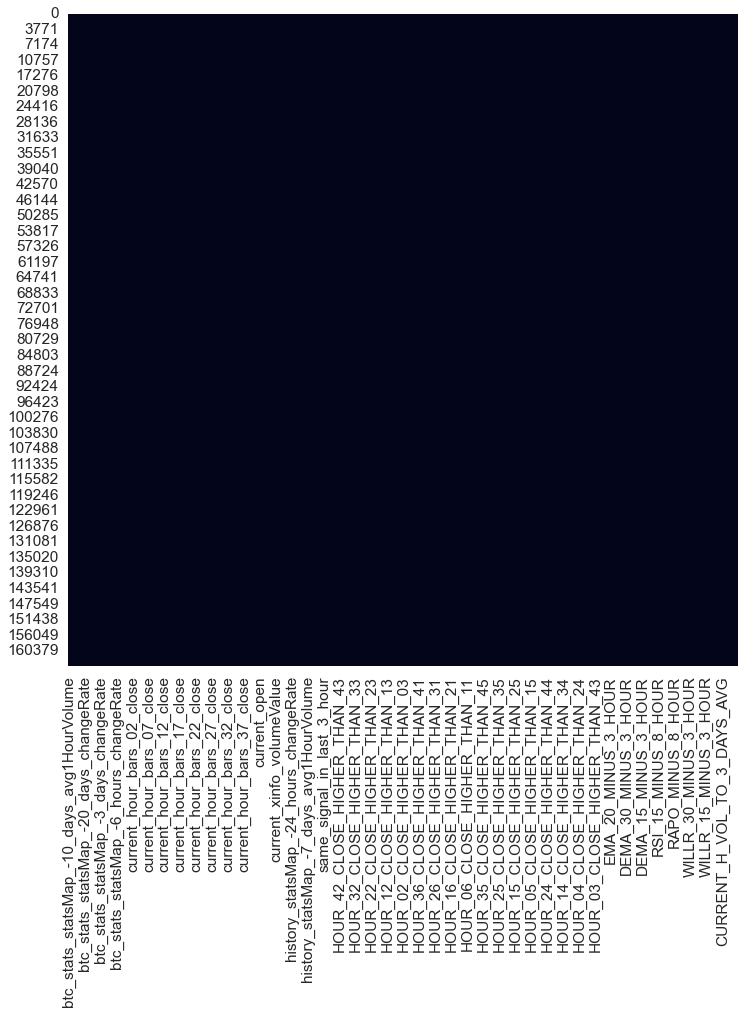

<AxesSubplot:>

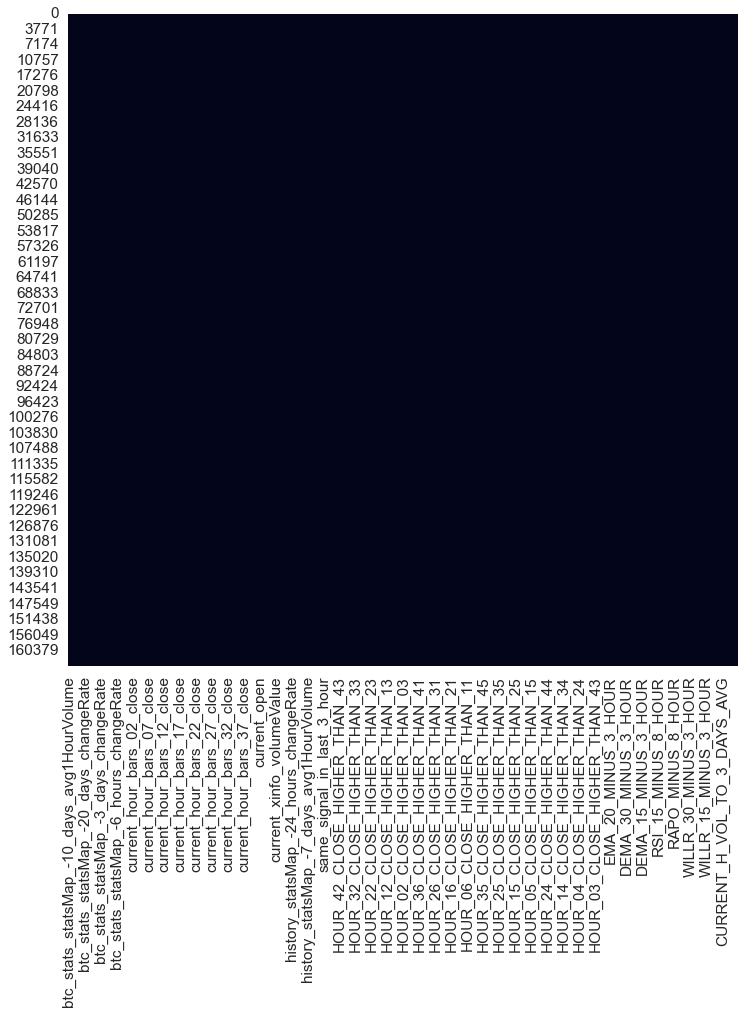

In [334]:
plt.figure(figsize=(12, 12))

sns.heatmap(df.isnull() | df.isna(), cbar=False)

In [276]:
# Initial try, with filling df with 0
df = df.fillna(0)

In [277]:
# if volume is negative - replace with zero
DataPreprocessor.replace_negative_volumes(df)

In [278]:
#already added as 'latest_hour_volume'
#DataPreprocessor.add_current_hour_volume(df)

In [279]:
history_vol_cols = DataPreprocessor.add_current_hour_volume_to_historical_volumes_coef(df)

In [280]:
next(history_vol_cols)

['history_statsMap_-10_days_avg1HourVolume', 'history_statsMap_-12_hours_avg1HourVolume', 'history_statsMap_-14_days_avg1HourVolume', 'history_statsMap_-20_days_avg1HourVolume', 'history_statsMap_-24_hours_avg1HourVolume', 'history_statsMap_-28_days_avg1HourVolume', 'history_statsMap_-3_days_avg1HourVolume', 'history_statsMap_-5_days_avg1HourVolume', 'history_statsMap_-6_hours_avg1HourVolume', 'history_statsMap_-7_days_avg1HourVolume']


['CURRENT_H_VOL_TO_10_DAYS_AVG',
 'CURRENT_H_VOL_TO_12_HOURS_AVG',
 'CURRENT_H_VOL_TO_14_DAYS_AVG',
 'CURRENT_H_VOL_TO_20_DAYS_AVG',
 'CURRENT_H_VOL_TO_24_HOURS_AVG',
 'CURRENT_H_VOL_TO_28_DAYS_AVG',
 'CURRENT_H_VOL_TO_3_DAYS_AVG',
 'CURRENT_H_VOL_TO_5_DAYS_AVG',
 'CURRENT_H_VOL_TO_6_HOURS_AVG',
 'CURRENT_H_VOL_TO_7_DAYS_AVG']

In [281]:
# finding corrupt data with excessive volumes, requires categorical features
#df[(df["id"] > 13000) & (df["id"] < 17000)].loc[::, ["id", "notification_date", *next(history_vol_cols)]].nlargest(n=3000, columns=['current_h_vol_to_28_days_avg'], keep='all')

In [282]:
# Which signal made best return?
df[df['LABEL_UP_RETURN'] == df['LABEL_UP_RETURN'].max()].loc[:, ['price', 'LABEL_UP_RETURN']]

,price,LABEL_UP_RETURN
73495,0.1492,3251.13941
73576,0.1492,3251.13941
73670,0.1492,3251.13941


In [283]:
# Which signal made worst return?
df[df['LABEL_DOWN_RETURN'] == df['LABEL_DOWN_RETURN'].min()].loc[:, ['price', 'LABEL_DOWN_RETURN']]

,price,LABEL_DOWN_RETURN
44678,0.13424,-98.279201


In [284]:
df_vol = df[[*next(history_vol_cols), 'LABEL_UP_RETURN', 'LABEL_DOWN_RETURN']]
x = df_vol.drop(['LABEL_UP_RETURN', 'LABEL_DOWN_RETURN'], 1)

# cleaning outliers in data
df_vol_coef_clean = df_vol[((x > x.quantile(.03)) & (x < x.quantile(.97))).all(1)]
#df_vol_coef_clean = df_vol[(np.abs(stats.zscore(df_vol)) < 4).all(axis=1)]
df_vol_coef_clean.shape

C:\Users\hustlestar\AppData\Local\Temp\ipykernel_3716\981079961.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = df_vol.drop(['LABEL_UP_RETURN','LABEL_DOWN_RETURN'], 1)


(102927, 12)

<AxesSubplot:>

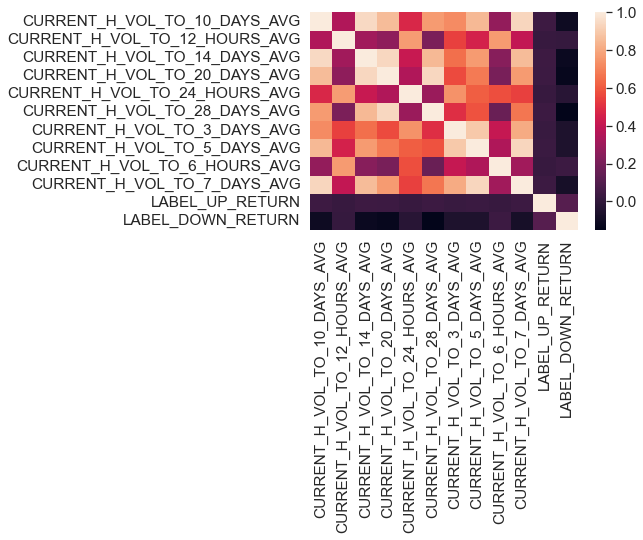

In [285]:
sns.heatmap(df_vol_coef_clean.corr())

In [286]:
df = next(DataPreprocessor.remove_outliers(df, history_vol_cols))
df.shape

D:\Projects\trading-bot-ml\src\data\preprocessing.py:229: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = df_vol.drop(['LABEL_UP_RETURN', 'LABEL_DOWN_RETURN'], 1)


(118530, 414)

In [287]:
# removing those which don't have -3 hours of data
df = DataPreprocessor.remove_rows_with_less_than_3_hours(df)
df.shape

(115685, 414)

<AxesSubplot:>

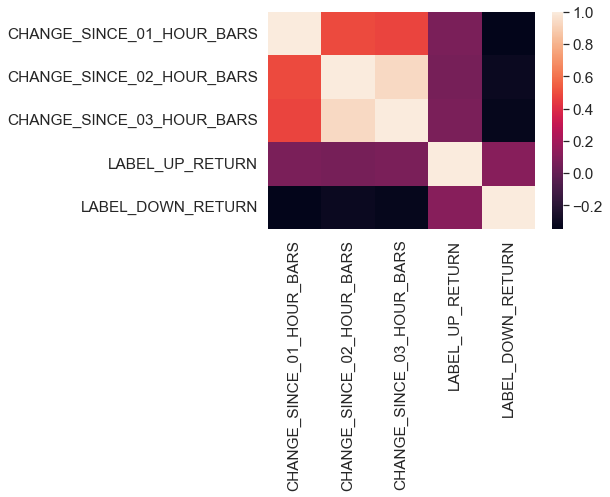

In [288]:
df_change_since_previous = next(DataPreprocessor.add_change_since_1_2_3_hours_back(df))
sns.heatmap(df_change_since_previous.corr())

C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CHANGE_SINCE_01_HOUR_BARS', ylabel='LABEL_DOWN_RETURN'>

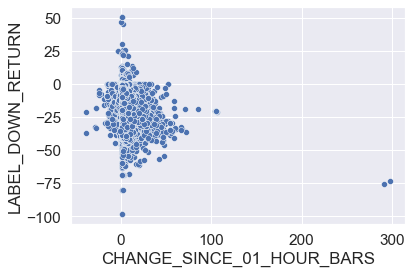

In [289]:
# there is some reverse correlation in change and down return
sns.scatterplot(df['CHANGE_SINCE_01_HOUR_BARS'], df['LABEL_DOWN_RETURN'])

<AxesSubplot:>

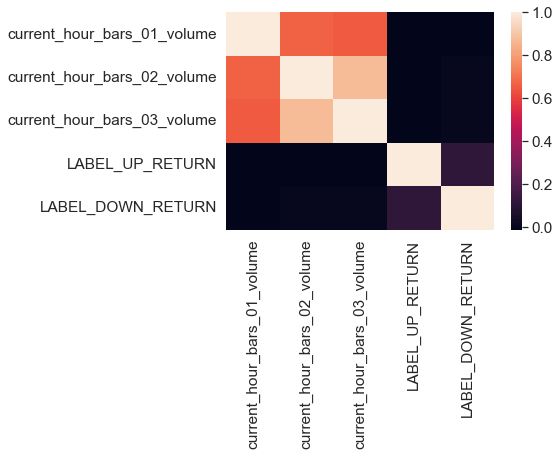

In [290]:
df_volume_on_previous = df[['current_hour_bars_01_volume',
                            'current_hour_bars_02_volume',
                            'current_hour_bars_03_volume',
                            'LABEL_UP_RETURN', 'LABEL_DOWN_RETURN']]
sns.heatmap(df_volume_on_previous.corr())

<AxesSubplot:>

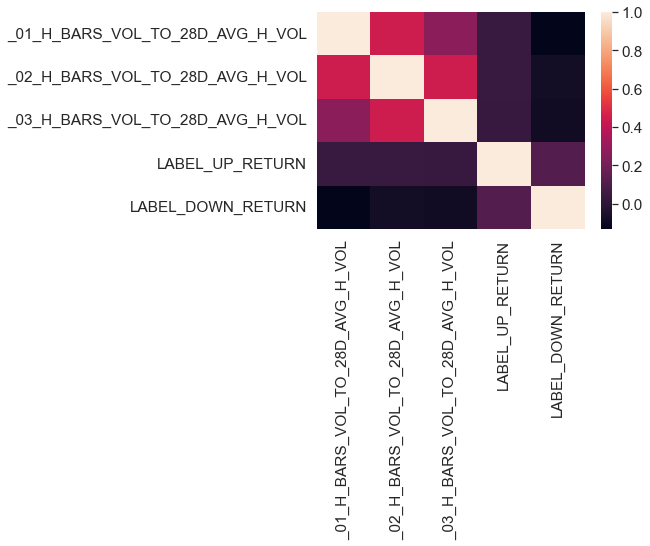

In [291]:
DataPreprocessor.add_1_2_3_h_bars_vol_to_history_vol_coef(df)
df_volume_on_previous_as_coef = df[['_01_H_BARS_VOL_TO_28D_AVG_H_VOL',
                                    '_02_H_BARS_VOL_TO_28D_AVG_H_VOL',
                                    '_03_H_BARS_VOL_TO_28D_AVG_H_VOL',
                                    'LABEL_UP_RETURN', 'LABEL_DOWN_RETURN']]
sns.heatmap(df_volume_on_previous_as_coef.corr())

<AxesSubplot:>

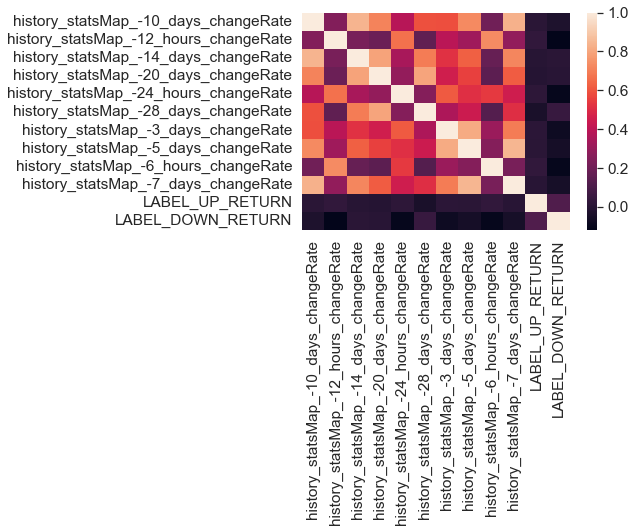

In [292]:
history_change_rate_cols = [c for c in df.columns if str(c).startswith('history_statsMap_-') and str(c).endswith('changeRate')]
df_history_change_rate = df[[*history_change_rate_cols, 'LABEL_UP_RETURN', 'LABEL_DOWN_RETURN']]
sns.heatmap(df_history_change_rate.corr())

In [293]:
df_vol_coef_clean[df_vol_coef_clean['CURRENT_H_VOL_TO_5_DAYS_AVG'] == df_vol_coef_clean['CURRENT_H_VOL_TO_5_DAYS_AVG'].max()]

,CURRENT_H_VOL_TO_10_DAYS_AVG,CURRENT_H_VOL_TO_12_HOURS_AVG,CURRENT_H_VOL_TO_14_DAYS_AVG,CURRENT_H_VOL_TO_20_DAYS_AVG,CURRENT_H_VOL_TO_24_HOURS_AVG,CURRENT_H_VOL_TO_28_DAYS_AVG,CURRENT_H_VOL_TO_3_DAYS_AVG,CURRENT_H_VOL_TO_5_DAYS_AVG,CURRENT_H_VOL_TO_6_HOURS_AVG,CURRENT_H_VOL_TO_7_DAYS_AVG,LABEL_UP_RETURN,LABEL_DOWN_RETURN
5070,16.845413,13.073395,17.014297,13.010543,15.374915,12.268472,21.166713,24.59269,11.440715,22.332806,6.626691,-8.241082


In [294]:
with_cat = df
with_cat['up_return'] = pd.cut(df['LABEL_UP_RETURN'],
                               bins=[0, 30, 40, 50, 70, 100, 300, float('Inf')],
                               labels=['0-30', '30-40', '40-50', '50-70', '70-100', '100-300', '300+'])

In [295]:
with_cat['down_return'] = pd.cut(df['LABEL_DOWN_RETURN'],
                                 bins=[float('-Inf'), -30, -20, -10, 0],
                                 labels=['-30', '-30-20', '-20-10', '-10-0'])

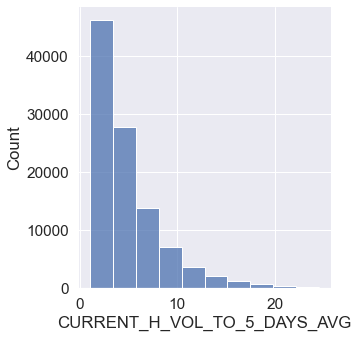

In [296]:
sns.displot(df_vol_coef_clean, x='CURRENT_H_VOL_TO_5_DAYS_AVG', bins=10)

<AxesSubplot:xlabel='up_return', ylabel='current_hour_bars_01_volume'>

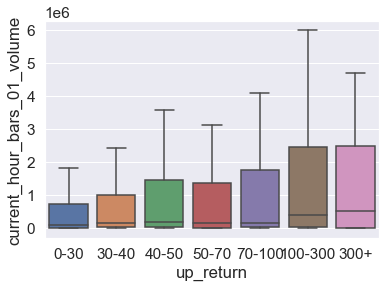

In [297]:
sns.boxplot(x='up_return', y='current_hour_bars_01_volume', data=with_cat, showfliers=False)

<AxesSubplot:xlabel='up_return', ylabel='current_hour_bars_02_volume'>

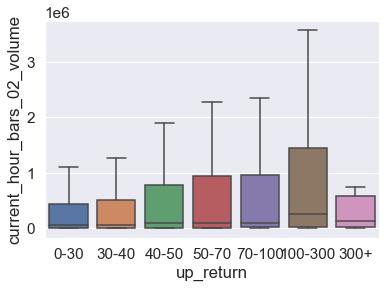

In [298]:
sns.boxplot(x='up_return', y='current_hour_bars_02_volume', data=with_cat, showfliers=False)

<AxesSubplot:xlabel='up_return', ylabel='current_hour_bars_03_volume'>

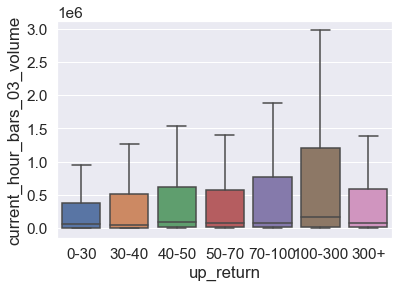

In [299]:
sns.boxplot(x='up_return', y='current_hour_bars_03_volume', data=with_cat, showfliers=False)

<AxesSubplot:xlabel='up_return', ylabel='CHANGE_SINCE_01_HOUR_BARS'>

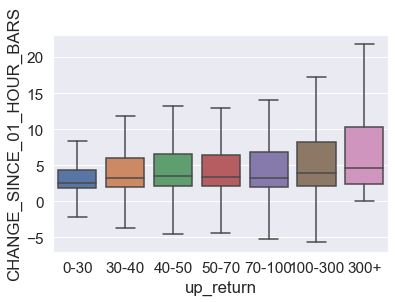

In [300]:
sns.boxplot(x='up_return', y='CHANGE_SINCE_01_HOUR_BARS', data=with_cat, showfliers=False)

<AxesSubplot:xlabel='up_return', ylabel='CHANGE_SINCE_02_HOUR_BARS'>

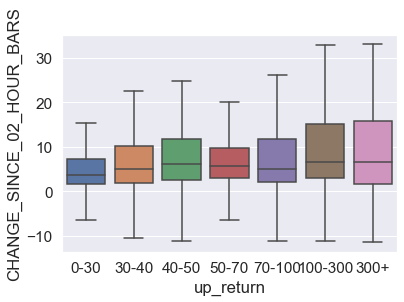

In [301]:
sns.boxplot(x='up_return', y='CHANGE_SINCE_02_HOUR_BARS', data=with_cat, showfliers=False)

<AxesSubplot:xlabel='up_return', ylabel='CHANGE_SINCE_03_HOUR_BARS'>

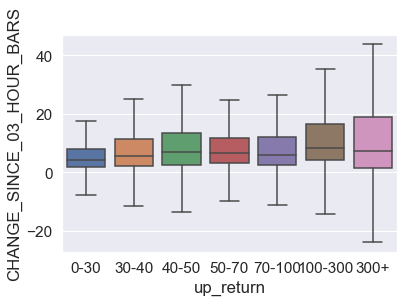

In [302]:
sns.boxplot(x='up_return', y='CHANGE_SINCE_03_HOUR_BARS', data=with_cat, showfliers=False)

<AxesSubplot:xlabel='down_return', ylabel='CHANGE_SINCE_01_HOUR_BARS'>

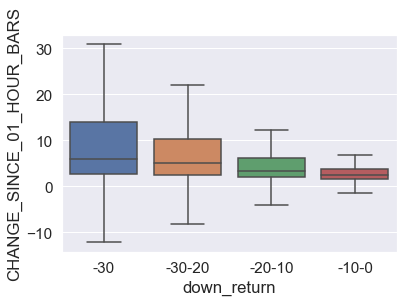

In [303]:
sns.boxplot(x='down_return', y='CHANGE_SINCE_01_HOUR_BARS', data=with_cat, showfliers=False)

<AxesSubplot:xlabel='down_return', ylabel='CHANGE_SINCE_02_HOUR_BARS'>

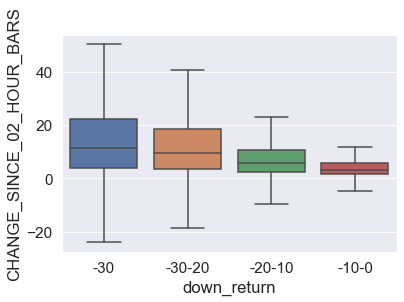

In [304]:
sns.boxplot(x='down_return', y='CHANGE_SINCE_02_HOUR_BARS', data=with_cat, showfliers=False)

<AxesSubplot:xlabel='down_return', ylabel='CHANGE_SINCE_03_HOUR_BARS'>

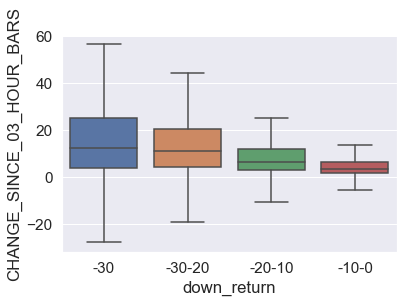

In [305]:
sns.boxplot(x='down_return', y='CHANGE_SINCE_03_HOUR_BARS', data=with_cat, showfliers=False)

<AxesSubplot:xlabel='up_return', ylabel='CURRENT_H_VOL_TO_5_DAYS_AVG'>

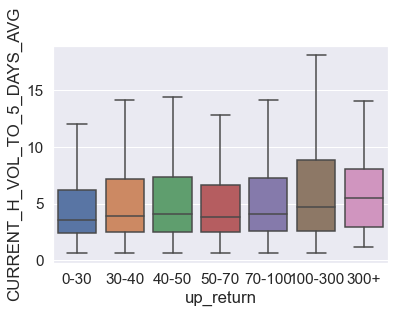

In [306]:
sns.boxplot(x='up_return', y='CURRENT_H_VOL_TO_5_DAYS_AVG', data=with_cat, showfliers=False)

<AxesSubplot:xlabel='up_return', ylabel='CURRENT_H_VOL_TO_14_DAYS_AVG'>

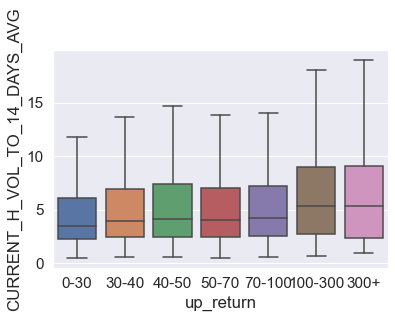

In [307]:
sns.boxplot(x='up_return', y='CURRENT_H_VOL_TO_14_DAYS_AVG', data=with_cat, showfliers=False)

<AxesSubplot:xlabel='up_return', ylabel='CURRENT_H_VOL_TO_28_DAYS_AVG'>

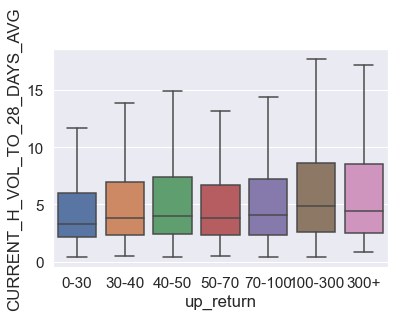

In [308]:
sns.boxplot(x='up_return', y='CURRENT_H_VOL_TO_28_DAYS_AVG', data=with_cat, showfliers=False)

<AxesSubplot:xlabel='down_return', ylabel='CURRENT_H_VOL_TO_5_DAYS_AVG'>

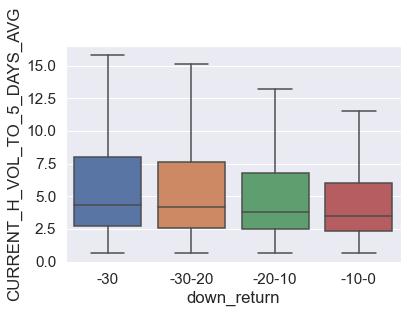

In [309]:
sns.boxplot(x='down_return', y='CURRENT_H_VOL_TO_5_DAYS_AVG', data=with_cat, showfliers=False)

<AxesSubplot:xlabel='down_return', ylabel='CURRENT_H_VOL_TO_28_DAYS_AVG'>

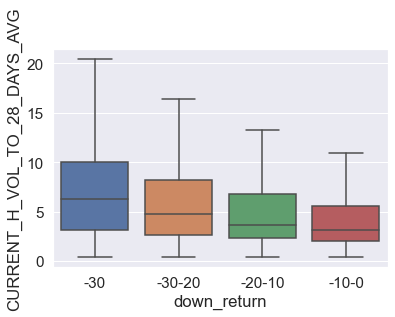

In [310]:
sns.boxplot(x='down_return', y='CURRENT_H_VOL_TO_28_DAYS_AVG', data=with_cat, showfliers=False)

In [311]:
df_vol_coef_clean.nlargest(n=20, columns=['CURRENT_H_VOL_TO_5_DAYS_AVG'], keep='all')

,CURRENT_H_VOL_TO_10_DAYS_AVG,CURRENT_H_VOL_TO_12_HOURS_AVG,CURRENT_H_VOL_TO_14_DAYS_AVG,CURRENT_H_VOL_TO_20_DAYS_AVG,CURRENT_H_VOL_TO_24_HOURS_AVG,CURRENT_H_VOL_TO_28_DAYS_AVG,CURRENT_H_VOL_TO_3_DAYS_AVG,CURRENT_H_VOL_TO_5_DAYS_AVG,CURRENT_H_VOL_TO_6_HOURS_AVG,CURRENT_H_VOL_TO_7_DAYS_AVG,LABEL_UP_RETURN,LABEL_DOWN_RETURN
5070,16.845413,13.073395,17.014297,13.010543,15.374915,12.268472,21.166713,24.592690,11.440715,22.332806,6.626691,-8.241082
40281,12.930226,12.872426,13.101369,10.515848,14.614567,11.489147,21.258385,24.575759,6.950937,16.198833,7.930347,-7.676964
40283,12.930226,12.872426,13.101369,10.515848,14.614567,11.489147,21.258385,24.575759,6.950937,16.198833,7.930347,-7.676964
79170,6.522872,34.010611,7.737805,8.556661,17.779559,4.120833,24.005495,24.573492,59.273531,5.314579,29.121179,-8.815502
97393,20.264893,5.029893,10.374275,10.800480,8.531723,13.325966,18.720441,24.531186,2.793509,21.797386,2.862069,-23.396552
...,...,...,...,...,...,...,...,...,...,...,...,...
5786,21.709848,15.549329,19.200848,21.027260,25.154166,20.228834,21.937712,24.166598,36.941281,22.110923,0.000000,-15.483871
76036,3.462814,16.595903,3.573850,4.461606,13.659847,5.314380,16.842189,24.150803,14.782686,14.591557,6.007569,-8.325449
157934,18.773852,22.053450,18.044772,15.218173,17.635054,6.473726,22.292646,24.094561,28.069989,16.363747,9.296686,-14.470493
157935,18.773852,22.053450,18.044772,15.218173,17.635054,6.473726,22.292646,24.094561,28.069989,16.363747,9.296686,-14.470493


In [312]:
# 10 largest by up return
df_vol_coef_clean.nlargest(n=20, columns=['LABEL_UP_RETURN'], keep='all')

,CURRENT_H_VOL_TO_10_DAYS_AVG,CURRENT_H_VOL_TO_12_HOURS_AVG,CURRENT_H_VOL_TO_14_DAYS_AVG,CURRENT_H_VOL_TO_20_DAYS_AVG,CURRENT_H_VOL_TO_24_HOURS_AVG,CURRENT_H_VOL_TO_28_DAYS_AVG,CURRENT_H_VOL_TO_3_DAYS_AVG,CURRENT_H_VOL_TO_5_DAYS_AVG,CURRENT_H_VOL_TO_6_HOURS_AVG,CURRENT_H_VOL_TO_7_DAYS_AVG,LABEL_UP_RETURN,LABEL_DOWN_RETURN
73495,8.737095,1.454004,4.787456,2.367516,2.592746,1.708372,5.385174,7.507256,1.009482,8.489879,3251.139410,-1.407507
73670,7.798065,1.297733,4.272919,2.113064,2.314087,1.524763,4.806396,6.700405,0.900986,7.577419,3251.139410,-1.407507
73692,8.621384,1.434748,4.724053,2.336161,2.558408,1.685747,5.313855,7.407833,0.996112,8.377443,3248.894843,-1.473543
76224,5.227816,0.864412,4.007987,1.992796,0.918114,1.426753,2.300394,3.509145,0.874727,4.291979,2965.542612,-4.291845
76249,7.153787,1.182869,5.484562,2.726959,1.256354,1.952381,3.147878,4.801943,1.196983,5.873180,2791.787160,-9.716599
...,...,...,...,...,...,...,...,...,...,...,...,...
39614,3.396695,5.861875,3.957099,4.959465,1.610743,4.852916,2.700111,3.607918,8.295423,4.400807,777.493495,0.000000
33597,2.970117,5.678851,1.799075,1.430237,9.286274,1.860895,5.844895,4.958365,6.048252,3.643588,655.911330,-6.650246
33599,2.970117,5.678851,1.799075,1.430237,9.286274,1.860895,5.844895,4.958365,6.048252,3.643588,655.911330,-6.650246
33615,3.475162,3.257004,2.164647,1.703788,4.387069,2.213462,5.678902,5.675372,1.947975,4.490166,628.978622,-6.413302


In [313]:
# 10 smallest by down return
df_vol_coef_clean.nsmallest(n=20, columns=['LABEL_DOWN_RETURN'], keep='all')

,CURRENT_H_VOL_TO_10_DAYS_AVG,CURRENT_H_VOL_TO_12_HOURS_AVG,CURRENT_H_VOL_TO_14_DAYS_AVG,CURRENT_H_VOL_TO_20_DAYS_AVG,CURRENT_H_VOL_TO_24_HOURS_AVG,CURRENT_H_VOL_TO_28_DAYS_AVG,CURRENT_H_VOL_TO_3_DAYS_AVG,CURRENT_H_VOL_TO_5_DAYS_AVG,CURRENT_H_VOL_TO_6_HOURS_AVG,CURRENT_H_VOL_TO_7_DAYS_AVG,LABEL_UP_RETURN,LABEL_DOWN_RETURN
44678,1.821486,0.809498,2.535469,3.496362,1.366162,3.241869,1.096354,1.256092,0.675737,1.383904,0.193683,-98.279201
48176,5.294728,21.105988,5.438348,4.357311,19.611853,3.170416,7.211148,4.186964,17.178768,5.109864,0.000000,-80.162885
48175,5.294728,21.105988,5.438348,4.357311,19.611853,3.170416,7.211148,4.186964,17.178768,5.109864,0.555718,-80.052647
157677,7.564388,7.241937,7.132592,7.300593,7.068864,7.367365,7.162084,7.435527,7.195168,7.465253,0.000000,-75.550756
159351,8.181061,8.196395,8.220200,7.893775,8.136395,8.092397,8.069189,8.158620,7.432953,8.330994,7.624709,-73.520832
...,...,...,...,...,...,...,...,...,...,...,...,...
81553,11.033964,1.550672,9.037248,12.457115,1.751922,17.217960,4.412689,6.764909,1.922126,8.452635,3.684211,-61.842105
22595,4.459873,1.570730,5.355117,6.025016,2.557943,6.048739,2.915157,2.701424,1.088834,3.533894,4.247104,-61.601397
50257,5.360110,6.490446,3.624059,4.610351,6.455715,4.855538,6.879866,7.485256,24.662288,5.162598,6.224066,-60.796680
81535,8.485579,1.192532,6.950021,9.580042,1.347301,13.241330,3.393542,5.202497,1.478195,6.500429,6.775068,-60.704607


In [314]:
# for c in  history_vol_cols:
#     sns.displot(df_vol_coef_clean[c], stat = 'density', binwidth=3)

In [315]:
#list(df.columns)

In [316]:
df.describe()

,btc_stats_statsMap_-10_days_avg1HourVolume,btc_stats_statsMap_-10_days_changeRate,btc_stats_statsMap_-10_days_high,btc_stats_statsMap_-12_hours_avg1HourVolume,btc_stats_statsMap_-12_hours_changeRate,btc_stats_statsMap_-12_hours_high,btc_stats_statsMap_-14_days_avg1HourVolume,btc_stats_statsMap_-14_days_changeRate,btc_stats_statsMap_-14_days_high,btc_stats_statsMap_-20_days_avg1HourVolume,btc_stats_statsMap_-20_days_changeRate,btc_stats_statsMap_-20_days_high,btc_stats_statsMap_-24_hours_avg1HourVolume,btc_stats_statsMap_-24_hours_changeRate,btc_stats_statsMap_-24_hours_high,btc_stats_statsMap_-28_days_avg1HourVolume,btc_stats_statsMap_-28_days_changeRate,btc_stats_statsMap_-28_days_close,btc_stats_statsMap_-28_days_high,btc_stats_statsMap_-3_days_avg1HourVolume,btc_stats_statsMap_-3_days_changeRate,btc_stats_statsMap_-3_days_high,btc_stats_statsMap_-5_days_avg1HourVolume,btc_stats_statsMap_-5_days_changeRate,btc_stats_statsMap_-5_days_high,btc_stats_statsMap_-60_days_avg1HourVolume,btc_stats_statsMap_-60_days_changeRate,btc_stats_statsMap_-60_days_close,btc_stats_statsMap_-60_days_high,btc_stats_statsMap_-6_hours_avg1HourVolume,btc_stats_statsMap_-6_hours_changeRate,btc_stats_statsMap_-6_hours_high,btc_stats_statsMap_-7_days_avg1HourVolume,btc_stats_statsMap_-7_days_changeRate,btc_stats_statsMap_-7_days_high,current_close,current_currentHourlyBarVolume,current_currentMinutelyBarVolume,current_hour_bars_01_close,current_hour_bars_01_volume,current_hour_bars_02_close,current_hour_bars_02_volume,current_hour_bars_03_close,current_hour_bars_03_volume,current_hour_bars_04_close,current_hour_bars_04_volume,current_hour_bars_05_close,current_hour_bars_05_volume,current_hour_bars_06_close,current_hour_bars_06_volume,current_hour_bars_07_close,current_hour_bars_07_volume,current_hour_bars_08_close,current_hour_bars_08_volume,current_hour_bars_09_close,current_hour_bars_09_volume,current_hour_bars_10_close,current_hour_bars_10_volume,current_hour_bars_11_close,current_hour_bars_11_volume,current_hour_bars_12_close,current_hour_bars_12_volume,current_hour_bars_13_close,current_hour_bars_13_volume,current_hour_bars_14_close,current_hour_bars_14_volume,current_hour_bars_15_close,current_hour_bars_15_volume,current_hour_bars_16_close,current_hour_bars_16_volume,current_hour_bars_17_close,current_hour_bars_17_volume,current_hour_bars_18_close,current_hour_bars_18_volume,current_hour_bars_19_close,current_hour_bars_19_volume,current_hour_bars_20_close,current_hour_bars_20_volume,current_hour_bars_21_close,current_hour_bars_21_volume,current_hour_bars_22_close,current_hour_bars_22_volume,current_hour_bars_23_close,current_hour_bars_23_volume,current_hour_bars_24_close,current_hour_bars_24_volume,current_hour_bars_25_close,current_hour_bars_25_volume,current_hour_bars_26_close,current_hour_bars_26_volume,current_hour_bars_27_close,current_hour_bars_27_volume,current_hour_bars_28_close,current_hour_bars_28_volume,current_hour_bars_29_close,current_hour_bars_29_volume,current_hour_bars_30_close,current_hour_bars_30_volume,current_hour_bars_31_close,current_hour_bars_31_volume,current_hour_bars_32_close,current_hour_bars_32_volume,current_hour_bars_33_close,current_hour_bars_33_volume,current_hour_bars_34_close,current_hour_bars_34_volume,current_hour_bars_35_close,current_hour_bars_35_volume,current_hour_bars_36_close,current_hour_bars_36_volume,current_hour_bars_37_close,current_hour_bars_37_volume,current_hour_bars_38_close,current_hour_bars_38_volume,current_hour_bars_39_close,current_hour_bars_39_volume,current_lastMinutelyBar_high,current_lastMinutelyBar_low,current_lastMinutelyBar_open,current_lastMinutelyBar_volume,current_open,current_xinfo_ask,current_xinfo_averagePrice,current_xinfo_bid,current_xinfo_changePrice,current_xinfo_changeRate,current_xinfo_high,current_xinfo_last,current_xinfo_low,current_xinfo_volume,current_xinfo_volumeValue,history_statsMap_-10_days_avg1HourVolume,history_statsMap_-10_days_changeRate,history_statsMap_-12_

In [317]:
from data.scalers import min_max_scaler, standard_scaler

In [336]:
df = DataPreprocessor.clean_dataset(df)
df.shape

(115683, 420)

In [323]:
df = df.drop(['UP_RETURN', 'DOWN_RETURN'], axis=1)
df_norm = min_max_scaler(df)
df_std = standard_scaler(df)
##%%
#corr = df.corr()['label_up_return']
##%%
#pd.set_option('display.max_rows', None)  # or 1000
#abs(corr).sort_values(ascending=False)
##%%
#pd.set_option('display.max_rows', 10)  # or 1000

KeyError: "['UP_RETURN', 'DOWN_RETURN'] not found in axis"

In [342]:
label_cols = ['LABEL_UP_RETURN', 'LABEL_DOWN_RETURN']
x = df.drop(label_cols, axis=1)
y_up = df['LABEL_UP_RETURN']
y_down = df['LABEL_DOWN_RETURN']

x_norm = df_norm.drop(label_cols, axis=1)
y_up_norm = df_norm['LABEL_UP_RETURN']
y_down_norm = df_norm['LABEL_DOWN_RETURN']

x_std = df_std.drop(label_cols, axis=1)
y_up_std = df_std['LABEL_UP_RETURN']
y_down_std = df_std['LABEL_DOWN_RETURN']

In [343]:
# EDA using SWEETVIZ automl library
#import sweetviz as sv
#sv_report = sv.analyze(df, pairwise_analysis='off')
#sv_report.show_html("sv.html")

In [344]:
from model_factory import ModelFactory

_, y_up_class = ModelFactory.prepare_classification_label(df, 20)
y_up_class.value_counts()

LABEL_20_UP
0              98117
1              17566
dtype: int64

In [345]:
_, y_down_class = ModelFactory.prepare_classification_label(df, -10)
y_down_class.value_counts()

LABEL_-10_DOWN
1                 73146
0                 42537
dtype: int64

In [346]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


def train_random_forest_clasifier(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    rfc = ExtraTreesClassifier()
    rfc.fit(x_train, y_train)
    return x_train, x_test, y_train, y_test, rfc

In [347]:
def train_logistic_regression_clasifier(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    from sklearn.linear_model import LogisticRegression
    rfc = LogisticRegression(max_iter=5000, penalty="l2")
    rfc.fit(x_train, y_train)
    return x_train, x_test, y_train, y_test, rfc

In [348]:
x_up_class, x_up_test_class, y_train_up_class, y_up_test_class, up_random_forest_model = train_random_forest_clasifier(x, y_up_class)

C:\Users\hustlestar\AppData\Local\Temp\ipykernel_3716\3762084726.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train, y_train)


In [349]:
def eval_model(x_up_class, x_up_test_class, y_up_class, y_up_test_class, up_random_forest_model):
    # Make predictions for the test UP set
    y_up_predictions = up_random_forest_model.predict(x_up_test_class)
    # View accuracy score
    print(accuracy_score(y_up_test_class, y_up_predictions))

    # View confusion matrix for test data and predictions
    matrix = confusion_matrix(y_up_test_class, y_up_predictions)
    print(matrix)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(16, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size': 10},
                cmap=plt.cm.Greens, linewidths=0.2)

    # Add labels to the plot
    class_names = ['Higher than 20%', 'Lower Than 20%']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix for Random Forest Model')
    plt.show()
    # View the classification report for test data and predictions
    print(classification_report(y_up_test_class, y_up_predictions))


0.9732042527444031
[[9760   73]
 [ 237 1499]]


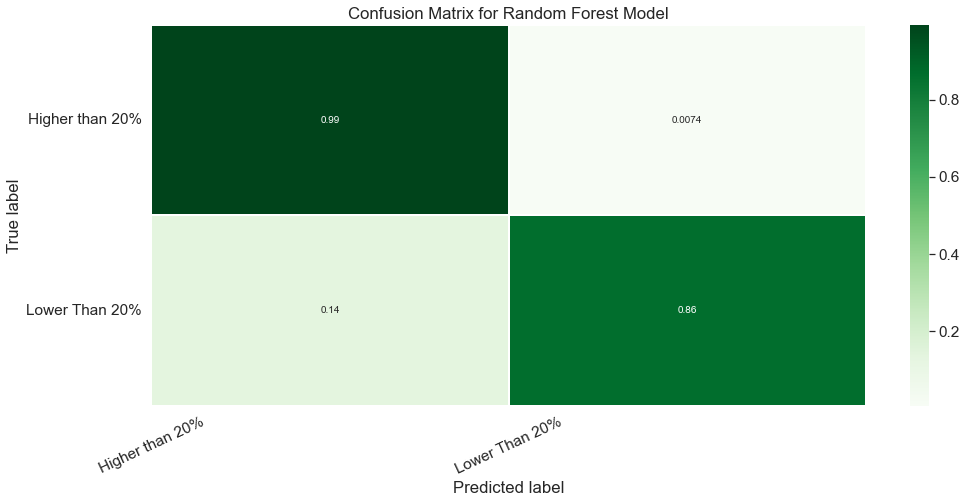

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      9833
           1       0.95      0.86      0.91      1736

    accuracy                           0.97     11569
   macro avg       0.96      0.93      0.95     11569
weighted avg       0.97      0.97      0.97     11569



In [350]:
eval_model(x_up_class, x_up_test_class, y_train_up_class, y_up_test_class, up_random_forest_model)

In [351]:
# from sklearn.tree import export_graphviz
# import os
# from sklearn import tree
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
# tree.plot_tree(up_random_forest_model.estimators_,
# feature_names=x_up_class.columns,
# class_names=y_train_up_class.columns,
# filled=True,
# rounded=True)
# fig.savefig('rf_individualtree.png')

In [352]:
importances = up_random_forest_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in up_random_forest_model.estimators_], axis=0)
std

array([0.00131656, 0.00100592, 0.00124361, 0.00089216, 0.00075458,
       0.00111327, 0.00155133, 0.00095293, 0.00138951, 0.00164329,
       0.00093253, 0.00141309, 0.00092647, 0.00079559, 0.00139654,
       0.00209431, 0.00108212, 0.00110547, 0.00125508, 0.00083969,
       0.00093671, 0.00103028, 0.00086176, 0.00074768, 0.00100335,
       0.00133374, 0.00151437, 0.00126894, 0.00119678, 0.00080668,
       0.00069656, 0.00111166, 0.00152158, 0.00089452, 0.00116935,
       0.00065802, 0.00050853, 0.000582  , 0.00067196, 0.00058933,
       0.00080227, 0.00058672, 0.0005775 , 0.00056338, 0.00064215,
       0.00058024, 0.00076639, 0.00060725, 0.00073479, 0.00058882,
       0.0006595 , 0.00057668, 0.00063155, 0.00061245, 0.00074501,
       0.0005353 , 0.00062489, 0.00062317, 0.00060653, 0.00063631,
       0.00076048, 0.00055054, 0.00058292, 0.00060148, 0.0006531 ,
       0.00051292, 0.00060716, 0.00058533, 0.0006019 , 0.00062436,
       0.00059519, 0.00047151, 0.00064934, 0.0005078 , 0.00066

In [356]:
pd.set_option('display.max_rows', 200)  # or 1000

In [357]:
forest_importances = pd.Series(importances, index=x_up_class.columns)
forest_importances.nlargest(200).tail(200)

current_xinfo_changeRate                       0.005930
CHANGE_SINCE_03_HOUR_BARS                      0.005621
history_statsMap_-14_days_changeRate           0.005342
CHANGE_SINCE_02_HOUR_BARS                      0.005228
history_statsMap_-10_days_changeRate           0.005156
history_statsMap_-28_days_changeRate           0.005101
history_statsMap_-7_days_changeRate            0.005074
history_statsMap_-20_days_changeRate           0.004991
history_statsMap_-5_days_changeRate            0.004749
history_statsMap_-3_days_changeRate            0.004648
CHANGE_SINCE_01_HOUR_BARS                      0.004621
history_statsMap_-12_hours_changeRate          0.004591
history_statsMap_-6_hours_changeRate           0.004511
btc_stats_statsMap_-28_days_avg1HourVolume     0.004483
current_xinfo_changePrice                      0.004393
_03_H_BARS_VOL_TO_28D_AVG_H_VOL                0.004367
btc_stats_statsMap_-20_days_avg1HourVolume     0.004248
_02_H_BARS_VOL_TO_28D_AVG_H_VOL                0

In [360]:
import os

forest_importances.sort_values(ascending=False).to_csv(os.path.join('..', 'eda', 'feature_importance_20220901.csv'))

In [ ]:
eval_model(*train_logistic_regression_clasifier(x_std, y_up_class))

In [ ]:
x_down_class, x_down_test_class, y_down_train_class, y_down_test_class, down_random_forest_model = train_random_forest_clasifier(x, y_down_class)

In [ ]:
# Make predictions for the test DOWN set
y_down_predictions = down_random_forest_model.predict(x_down_test_class)
# View accuracy score
accuracy_score(y_down_test_class, y_down_predictions)

In [ ]:
# View confusion matrix for test data and predictions
matrix = confusion_matrix(y_down_test_class, y_down_predictions)
matrix

In [ ]:
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16, 7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size': 10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Lower than -10%', 'Higher Than -10%']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
forest_importances = pd.Series(down_random_forest_model.feature_importances_, index=x_down_class.columns)
forest_importances.nlargest(50)

In [ ]:
# View the classification report for test data and predictions
print(classification_report(y_down_test_class, y_down_predictions))

In [ ]:
# check stats using OLS from statsmodels
#import statsmodels.api as sm
#results = sm.OLS(y_up,x).fit()
#results.summary()

